In [1]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

import pathlib

import tensorflow as tf
import tensorflow_hub as hub

Versions of key libraries
---
tensorflow:  2.9.2
numpy:       1.22.4
matplotlib:  3.5.3
sklearn:     1.1.2


In [2]:
data_dir = '/Users/santi/apps/tensorflow/datasets/state-farm-distracted-driver-detection/imgs/train/'
data_dir = pathlib.Path(data_dir)
print(data_dir)

# val_dir = '/Users/santi/apps/tensorflow/datasets/driver-fatigue/output/val/'
# val_dir = pathlib.Path(val_dir)
# print(val_dir)

test_dir = '/Users/santi/apps/tensorflow/datasets/state-farm-distracted-driver-detection/imgs/testresult/'
test_dir = pathlib.Path(test_dir)
print(test_dir)

/Users/santi/apps/tensorflow/datasets/state-farm-distracted-driver-detection/imgs/train
/Users/santi/apps/tensorflow/datasets/state-farm-distracted-driver-detection/imgs/testresult


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

19578


In [4]:
batch_size = 100
img_height = 224
img_width = 224

IMAGE_SHAPE = (224, 224)

In [5]:
from keras.applications.vgg16 import VGG16, preprocess_input
# from tensorflow.keras.applications.MobileNetV2 import MobileNetV2

In [6]:
optmz       = 'adam' #     optimizers.RMSprop(learning_rate=0.0001)    
#modelname   = 'tl_driver_distraction_model_01' #normal all data
modelname   = 'tl_driver_distraction_model_02_RT' #remove c8 from training data
base_learning_rate = 0.0001
def createModel(inputShape=(img_height,img_width,3),numClasses=9):
    
  
    
#     conv_base = VGG16(include_top=False,
#                      weights='imagenet', 
#                      input_shape=inputShape)
    
    
    conv_base = tf.keras.applications.MobileNetV2(input_shape=inputShape,
                                               include_top=False,
                                               weights='imagenet')
    conv_base.trainable = False
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
#     top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(32, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)

#     top_model.trainable = False
    outputs = Dense(numClasses,
                activation='softmax')(top_model)
    
    model       = Model(inputs=conv_base.input,outputs=outputs)
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])    
    return model


model = createModel()
model.summary()   
    

2022-10-24 00:14:19.187957: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-24 00:14:19.188101: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                           

In [7]:
folderpath      = '/Users/santi/apps/tensorflow/model/'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: /Users/santi/apps/tensorflow/model/tl_driver_distraction_model_02_RT.hdf5
Path to log:   /Users/santi/apps/tensorflow/model/tl_driver_distraction_model_02_RT.csv


In [8]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

print("Path to plot:", plotpath)

Path to plot: /Users/santi/apps/tensorflow/model/tl_driver_distraction_model_02_RT_plot.png


In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 19578 files belonging to 9 classes.
Using 15663 files for training.


In [10]:
class_names = train_ds.class_names

In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 19578 files belonging to 9 classes.
Using 3915 files for validation.


In [12]:
history=model.fit(train_ds,                    # Training data
          validation_data=val_ds,   # Validation data and label
          epochs=40,                       # The amount of epochs to be trained
          batch_size=batch_size,                   
          shuffle=True,                     # To shuffle the training data
          callbacks=callbacks_list)         # Callbacks to execute the checkpoints


Epoch 1/40


2022-10-24 00:14:37.655238: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-24 00:14:37.655513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - ETA: 0s - loss: 2.0426 - accuracy: 0.1902

2022-10-24 00:14:55.185666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 23s 139ms/step - loss: 2.0426 - accuracy: 0.1902 - val_loss: 1.8054 - val_accuracy: 0.2825
Epoch 2/40
157/157 [==============================] - 21s 135ms/step - loss: 1.7910 - accuracy: 0.2683 - val_loss: 1.6530 - val_accuracy: 0.3803
Epoch 3/40
157/157 [==============================] - 21s 135ms/step - loss: 1.6841 - accuracy: 0.3621 - val_loss: 1.5623 - val_accuracy: 0.4871
Epoch 4/40
157/157 [==============================] - 21s 135ms/step - loss: 1.6108 - accuracy: 0.4044 - val_loss: 1.4806 - val_accuracy: 0.5269
Epoch 5/40
157/157 [==============================] - 21s 135ms/step - loss: 1.5428 - accuracy: 0.4298 - val_loss: 1.3893 - val_accuracy: 0.5504
Epoch 6/40
157/157 [==============================] - 22s 136ms/step - loss: 1.4763 - accuracy: 0.4506 - val_loss: 1.3215 - val_accuracy: 0.5686
Epoch 7/40
157/157 [==============================] - 22s 136ms/step - loss: 1.4316 - accuracy: 0.4569 - val_loss: 1.2566 - val_accuracy: 0.5

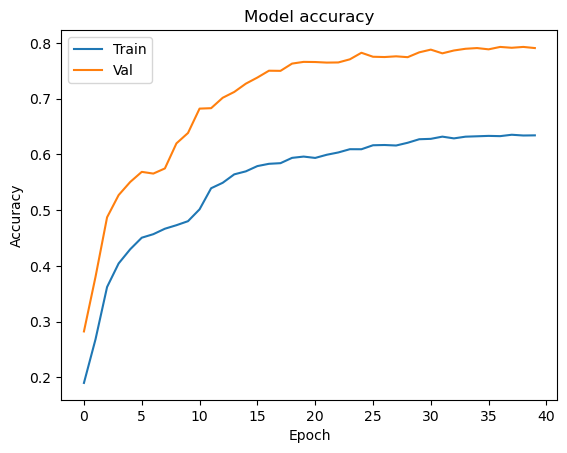

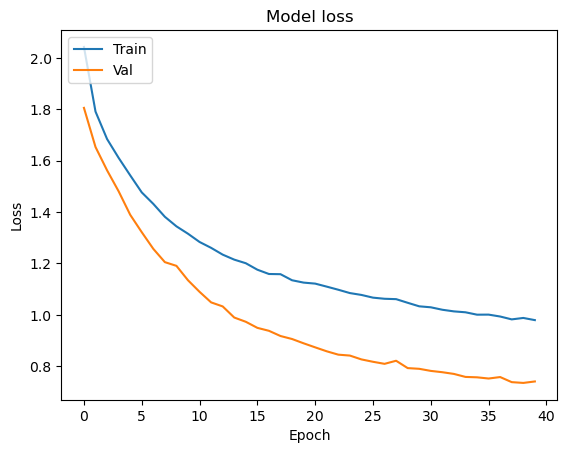

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [14]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=1)

Found 935 files belonging to 9 classes.


In [15]:
test_classes=test_ds.class_names 
predicts    = model.predict(test_ds)  

2022-10-24 00:29:08.759150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


935/935 [==============================] - 10s 10ms/step


In [16]:
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns

935/935 [==============================] - 10s 10ms/step
there were 766 correct predictions in 935 tests for an accuracy of  81.93 % 


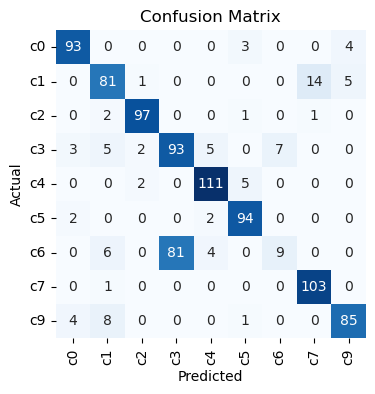

In [17]:
ytrue=[]
for images, label in test_ds:   
    for e in label:
        ytrue.append(test_classes[e]) # list of class names associated with each image file in test dataset 
ypred=[]
errors=0
count=0
preds=model.predict(test_ds, verbose=1) # predict on the test data
for i, p in enumerate(preds):
    count +=1
    index=np.argmax(p) # get index of prediction with highest probability
    klass=test_classes[index] 
    ypred.append(klass)  
    if klass != ytrue[i]:
        errors +=1
        
acc= (count-errors)* 100/count
msg=f'there were {count-errors} correct predictions in {count} tests for an accuracy of {acc:6.2f} % '
print(msg) 
ypred=np.array(ypred)
ytrue=np.array(ytrue)
if len(test_classes)<= 30: # if more than 30 classes plot is not useful to cramed
        # create a confusion matrix 
        cm = confusion_matrix(ytrue, ypred )        
        length=len(test_classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, test_classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, test_classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

In [18]:
testScores  = metrics.accuracy_score( ytrue,ypred)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(ytrue,
                                    ypred,
                                    target_names=test_classes,
                                    digits=4)) 

Best accuracy (on testing dataset): 81.93%
              precision    recall  f1-score   support

          c0     0.9118    0.9300    0.9208       100
          c1     0.7864    0.8020    0.7941       101
          c2     0.9510    0.9604    0.9557       101
          c3     0.5345    0.8087    0.6436       115
          c4     0.9098    0.9407    0.9250       118
          c5     0.9038    0.9592    0.9307        98
          c6     0.5625    0.0900    0.1552       100
          c7     0.8729    0.9904    0.9279       104
          c9     0.9043    0.8673    0.8854        98

    accuracy                         0.8193       935
   macro avg     0.8152    0.8165    0.7932       935
weighted avg     0.8125    0.8193    0.7936       935

